# Introduction


**Data**:
- Data from Segerstolpe et al. (https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-5061/results/cell-plots?ref=biostudies&plotOption=5&colourBy=inferred+cell+type+-+authors+labels) 
- Downloaded from https://ftp.ebi.ac.uk/pub/databases/microarray/data/atlas/sc_experiments/E-MTAB-5061/ 
- pancreatic islet cells from 10 donors (6 healthy, 4 with T2D)
- 3386 cells of scRNA (raw data)

**Workflow**:
1. Preprocess data
- Filtering: expressed & not informative genes  
- Normalization 
- Feature selection: PCA & Highly variable genes 
- Build graph  
2. GNN - cluster preprocess data
3. GNN - classifier to find important cells in T2D patients (diabetes type 2)

# Downloading & Preprocessing data


In [2]:
# Downloading raw data in data/raw folder
# Data is downloaded from NIH website -> GEO dataset -> Gene Expression Omnibus repository (curated gene expression DataSets
#!bash ../data/download_data.sh 

In [ ]:
import sys
path_to_module = '../src/data_preprocess.py'
path_to_module2 = '../src/graph_construction.py'
path_to_module3 = '../src/GNN_utils.py'
path_to_module4 = '../src/GNN_classificators.py'

import os
sys.path.append(os.path.dirname(path_to_module))
sys.path.append(os.path.dirname(path_to_module2))
sys.path.append(os.path.dirname(path_to_module3))
sys.path.append(os.path.dirname(path_to_module4))
import data_preprocess,graph_construction,GNN_clustering,GNN_classificators
import pandas as pd
import numpy as np
from scipy import stats


In [4]:
path_data="../data/raw/data.mtx.gz" 
path_rows="../data/raw/data_rows.txt"
path_cols="../data/raw/data_cols.txt" 
path_meta="../data/raw/cell_metadata.tsv" 
data=data_preprocess.read_rawdata(path_data,0)
gene_names=data_preprocess.read_rawdata(path_rows,0)
cell_meta=data_preprocess.read_rawdata(path_meta,0)

Shape check [#genes x # cells] : (40614, 3386)
Shape txt file : (40614, 1)
Shape tsv file : (3386, 35)


In [5]:
# Inspect the cell metadata columns to find donor health status information
print(cell_meta.columns.tolist())
print(cell_meta[['individual', 'disease']].head())  # assuming 'disease' column exists

['id', 'age', 'biosource_provider', 'body_mass_index', 'cell_type', 'clinical_information', 'disease', 'individual', 'organism_part', 'organism_status', 'organism', 'sex', 'single_cell_quality', 'submitted_single_cell_quality', 'inferred_cell_type_-_ontology_labels', 'inferred_cell_type_-_authors_labels', 'disease.1', 'single_cell_identifier', 'age_ontology', 'biosource_provider_ontology', 'body_mass_index_ontology', 'cell_type_ontology', 'clinical_information_ontology', 'disease_ontology', 'individual_ontology', 'organism_part_ontology', 'organism_status_ontology', 'organism_ontology', 'sex_ontology', 'single_cell_quality_ontology', 'submitted_single_cell_quality_ontology', 'inferred_cell_type_-_ontology_labels_ontology', 'inferred_cell_type_-_authors_labels_ontology', 'disease_ontology.1', 'single_cell_identifier_ontology']
  individual disease
0         H5  normal
1         H5  normal
2         H5  normal
3         H5  normal
4         H5  normal


In [6]:
# Create binary labels: 0 = healthy (normal), 1 = T2D
cell_meta['label'] = cell_meta['disease'].apply(lambda x: 1 if "diabetes" in str(x).lower() else 0)
labels = cell_meta['label'].values

# Verify label distribution
n_healthy = np.sum(labels == 0)
n_t2d = np.sum(labels == 1)
print(f"Healthy cells: {n_healthy}, T2D cells: {n_t2d}")


Healthy cells: 1900, T2D cells: 1486


## Preprocess

In [7]:
# Filtering

# Dead cells or bad quality (if expressed genes < (500-100))  (https://www.biorxiv.org/content/10.1101/483297v1.full)
df_filtered,labels_filtered,cell_meta=data_preprocess.filter_genes_expressed(data,labels,cell_meta,500) # chosen 500
#selected 10000 just per afterwards calculation and plots
# Filter non informative genes --> remove genes expressed in very few cells ( < 3)

df_filtered,gene_names=data_preprocess.filter_genes_not_informative(df_filtered,gene_names,minCells=5)


Cells with <500 expressed genes:  231
Cells remained after filtering: 3155
Genes with < 5 expressed cells: 11581
Filtered dimensions: (29033, 3155)


In [12]:
#df_norm=data_preprocess.normalize(df,1e4)
df_norm=data_preprocess.log_normalize(df_filtered)

df_reduced=data_preprocess.reduce_dimentionality(df_norm,50,'svd')
df_hvg,genes_hvg,top_index=data_preprocess.select_highly_variable_genes(df_norm,gene_names,1000)
'''# Save the dataframes to CSV files
savename="../data/processed/df_reduced.csv"
df_reduced_df = pd.DataFrame(df_reduced)  # Convert to DataFrame
#df_reduced_df.to_csv(savename, index=False)
savename="../data/processed/df_hvg.csv"
df_hvg_df = pd.DataFrame(df_hvg)  # Convert to DataFrame
df_hvg_df.to_csv(savename)'''

[10000. 10000. 10000. 10000. 10000.]
New dimensions:  (3155, 50)
Variance explained on first 5 PC: [0.10637917 0.07886064 0.04673    0.03375843 0.01989874]
Dimensions matrix HVG: (1000, 3155)
mean variance of HVG selected: 0.2056231068353148  - mean variance other genes: 0.05368337959497073


'# Save the dataframes to CSV files\nsavename="../data/processed/df_reduced.csv"\ndf_reduced_df = pd.DataFrame(df_reduced)  # Convert to DataFrame\n#df_reduced_df.to_csv(savename, index=False)\nsavename="../data/processed/df_hvg.csv"\ndf_hvg_df = pd.DataFrame(df_hvg)  # Convert to DataFrame\ndf_hvg_df.to_csv(savename)'

## Graph construction

Pearson correlation matrix
Threshold 0.9: around 696821 graph connections
Cosine similarity matrix
Threshold 0.9: around 703218 graph connections
Euclidean distance matrix
Threshold 0.9: around 0 graph connections
Data(x=[3155, 50], edge_index=[2, 1393642])
Graph with 25 nodes and 300 edges


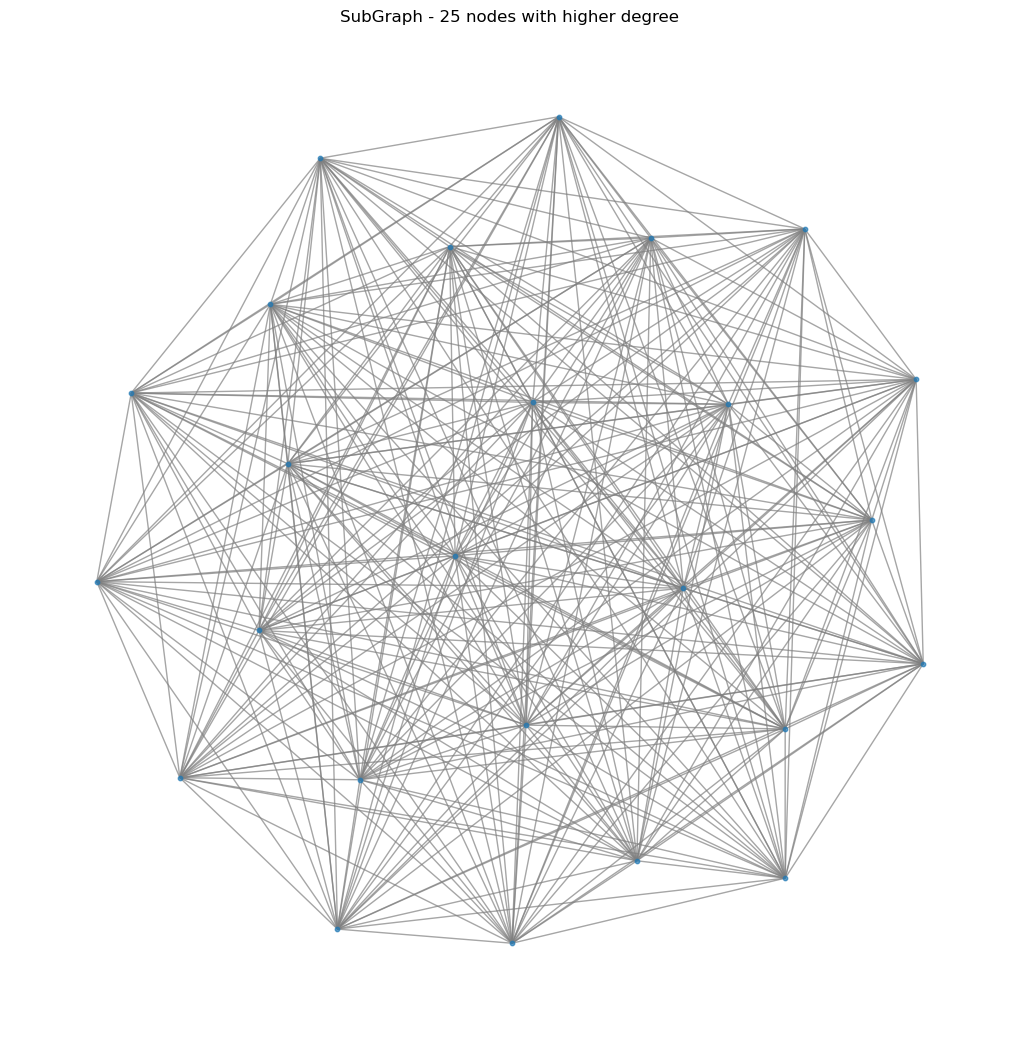

In [9]:
## From PCA matrix: n_cells x PCA_components ()

# Nodes: Cells
# Edges: connect cells with similar expression profile
# use Pearson correlation to calculate correlation between cells. Threshold =0.3
# Steps: 1. Matrix correlation, 2. Apply threshold to detect cell connectivity (simlarity). 3. Check diagonal is 0
#df=pd.DataFrame(df_reduced)
pearson_matrix,cos_matrix,eucl_matrix=graph_construction.adjacent_matrix(df_reduced,0.9)
# visualizing Graph
G_dataPCA,edge_indexPCA=graph_construction.createGraph(pearson_matrix,df_reduced,top_n=25)


In [ ]:
# from HVG genes

df_hvg=df_hvg.T.toarray() #to n_cells x n_genes_hvg

corr_matrix = np.corrcoef(df_hvg)  # compute NxN correlation matrix
threshold = 0.6
# Get edges where correlation > threshold (excluding self-correlations)
pearson_edges = np.argwhere((corr_matrix > threshold) & (np.eye(len(df_hvg)) == 0))
# pearson_edges will include each edge twice (i->j and j->i) since corr(i,j)==corr(j,i)

# Convert to edge index format for PyG (2 x E tensor)
pearson_edge_index = np.array(pearson_edges).T  # shape [2, num_edges]

In [15]:
from sklearn.neighbors import NearestNeighbors
# k-NN graph (k=10)
k = 10
nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(df_hvg)
distances, indices = nbrs.kneighbors(df_hvg)
# indices[i] includes i itself as first neighbor (distance 0). Exclude self neighbor:
knn_edges = []
for i in range(indices.shape[0]):   
    for j in indices[i, 1:]:  # skip indices[i,0] which is the point itself
        knn_edges.append([i, j])
        knn_edges.append([j, i])  # add reciprocal edge to make undirected
knn_edge_index = np.array(knn_edges).T  # shape [2, 2*N*k] (each edge added twice)

In [ ]:
# Visualize graph --ON PROGRESS NOT WORKING YET
'''
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import Data
edge_index = torch.tensor(knn_edge_index, dtype=torch.long)
# Create tensor of feature nodes
x = torch.tensor(df_hvg, dtype=torch.float)

# Creiamo l'oggetto Data di PyG
data = Data(x=x, edge_index=edge_index)
print(data)
G=to_networkx(data,edge_index, to_undirected=True)
        #Visualize the graph
plt.figure(figsize=(10, 10))
pos=nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False,
        node_size=10, node_color='skyblue', 
        alpha=0.5)
plt.title("Entire graph PCA 50 components")
plt.show()
'''

# GNN - Clustering
- Objective: unsupervised cluster

In [ ]:
from torch_geometric.nn import GCNConv, VGAE
import torch
# Iperparametri
num_features = G_data.num_node_features  # dimensione delle feature di input (50 se usiamo PCA)
hidden_dim = 32    # dimensione layer nascosto
latent_dim = 16    # dimensione spazio latente (embedding finale per ciascuna cellula)

# Inizializziamo il modello VGAE con l'encoder definito
encoder = GNN_clustering.GCNEncoder(num_features, hidden_dim, latent_dim)
model = VGAE(encoder)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

GNN_clustering.train(model, G_data, optimizer, epochs)


Epoch 10, Loss 296.5036
Epoch 20, Loss 76.6874
Epoch 30, Loss 54.0535
Epoch 40, Loss 47.5930
Epoch 50, Loss 44.1745
Epoch 60, Loss 41.7559
Epoch 70, Loss 40.1281
Epoch 80, Loss 38.7641
Epoch 90, Loss 37.5980
Epoch 100, Loss 36.5946


In [ ]:
# Get the embeddings
model.eval()
with torch.no_grad():
    z = model.encode(G_data.x, G_data.edge_index)  # z è un tensore di dimensione (n_cellule, latent_dim)
print("Embedding latente - shape:", z.shape)


Embedding latente - shape: torch.Size([3155, 16])


In [11]:
from sklearn.cluster import KMeans

k = 8  # numero di cluster voluto (ipotetico)
labels = KMeans(n_clusters=k, random_state=42).fit_predict(z.cpu().numpy())
# 'labels' è un array di lunghezza n_cellule con l'assegnazione di ogni cellula a uno dei k cluster


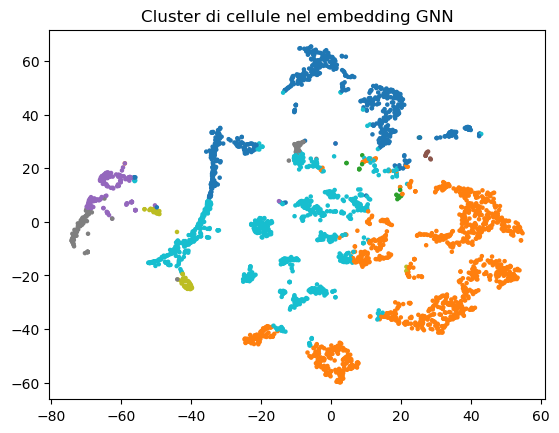

In [12]:
# Esempio: dimensionamento a 2D per visualizzare (PCA ulteriore o TSNE)
from sklearn.manifold import TSNE
X_2d = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(z.cpu().numpy())
import matplotlib.pyplot as plt

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', s=5)
plt.title("Cluster di cellule nel embedding GNN")
plt.show()


# GNN - Classificator

In [21]:
# Define hidden dimension and other hyperparameters
hidden_dim = 64  # number of hidden units in the first layer
num_classes = 2  # binary classification (healthy vs T2D)
dropout_rate = 0.5

In [22]:
# MODELS INSTANTIATION
# all models have 
# - 2 convolutional layers
# - RELU activation and droput between layers  

num_features = df_hvg.shape[1]  # 2000 HVG features
gcn_model = GNN_classificators.GCNNet(num_features, hidden_dim, num_classes)
sage_model = GNN_classificators.GraphSAGENet(num_features, hidden_dim, num_classes)
gat_model = GNN_classificators.GATNet(num_features, hidden_dim, num_classes)

NameError: name 'GNN_classificators' is not defined

In [ ]:
# TRAINING AND EVALUATION
metrics_gcn_pearson = GNN_classificators.evaluate_model_on_graph(gcn_model, pearson_edge_index, df_hvg, cell_meta['disease'],
                                                                 num_features,hidden_dim, num_classes, dropout_rate)
